# Cluster countries

In [1]:
# Import the required modules.
from bokeh.palettes import brewer
from bokeh.io import output_notebook, show
from bokeh.plotting import figure
from bokeh.models import HoverTool, PanTool, ResetTool, BoxZoomTool
import numpy as np
import pandas as pd
from sklearn.base import TransformerMixin
from sklearn.cluster import KMeans
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.manifold import TSNE
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
output_notebook()
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## Problem setting
 * Let's try to cluster the countries baased on the indicators of happiness.
 * Use UMAP on the Dataset

## Import data

In [2]:
import pandas as pd
url = 'https://raw.githubusercontent.com/tjoycalo/Python-for-machine-learning/master/source-code/scikit-learn/Data/world_happiness_2015.csv'
data_2015 = pd.read_csv(url)

In [14]:
data_2015.head()

,Country,Region,Happiness Rank,Happiness Score,Standard Error,Economy (GDP per Capita),Family,Health (Life Expectancy),Freedom,Trust (Government Corruption),Generosity,Dystopia Residual
0,Switzerland,Western Europe,1,7.587,0.03411,1.39651,1.34951,0.94143,0.66557,0.41978,0.29678,2.51738
1,Iceland,Western Europe,2,7.561,0.04884,1.30232,1.40223,0.94784,0.62877,0.14145,0.43630,2.70201
2,Denmark,Western Europe,3,7.527,0.03328,1.32548,1.36058,0.87464,0.64938,0.48357,0.34139,2.49204
3,Norway,Western Europe,4,7.522,0.03880,1.45900,1.33095,0.88521,0.66973,0.36503,0.34699,2.46531
4,Canada,North America,5,7.427,0.03553,1.32629,1.32261,0.90563,0.63297,0.32957,0.45811,2.45176


In [15]:
data_2015.describe()

,Happiness Rank,Happiness Score,Standard Error,Economy (GDP per Capita),Family,Health (Life Expectancy),Freedom,Trust (Government Corruption),Generosity,Dystopia Residual
count,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000
mean,79.493671,5.375734,0.047885,0.846137,0.991046,0.630259,0.428615,0.143422,0.237296,2.098977
std,45.754363,1.145010,0.017146,0.403121,0.272369,0.247078,0.150693,0.120034,0.126685,0.553550
min,1.000000,2.839000,0.018480,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.328580
25%,40.250000,4.526000,0.037268,0.545808,0.856823,0.439185,0.328330,0.061675,0.150553,1.759410
50%,79.500000,5.232500,0.043940,0.910245,1.029510,0.696705,0.435515,0.107220,0.216130,2.095415
75%,118.750000,6.243750,0.052300,1.158448,1.214405,0.811013,0.549092,0.180255,0.309883,2.462415
max,158.000000,7.587000,0.136930,1.690420,1.402230,1.025250,0.669730,0.551910,0.795880,3.602140


## Preprocess data

In [3]:
# Define a class to extract data from a pandas DataFrame.
class FeatureSelector(BaseException, TransformerMixin):
    def __init__(self, feature_names):
        self._feature_names = feature_names
    def fit(self, X, Y=None):
        return self
    def transform(self, X):
        return X[self._feature_names].values

In [4]:
# Define a transformer for the region names into one-hot encoding.
region_transformer = ColumnTransformer([('one_hot_encoder',
                                         OneHotEncoder(categories='auto'),
                                         ['Region'])])

In [5]:
# Define the names of the columns that hold numerical data.
num_attr_names = ['Economy (GDP per Capita)',
                  'Family', 'Health (Life Expectancy)', 'Freedom',
                  'Trust (Government Corruption)', 'Generosity',
                  'Dystopia Residual']

In [6]:
# Create a pipeline for the numerical attributes, rescaling them after selection.
num_attrs_pipeline = Pipeline([
    ('select_num_attrs', FeatureSelector(num_attr_names)),
    ('scaler', MinMaxScaler()),
])

In [7]:
preparation_pipeline = FeatureUnion(transformer_list=[
    ('region_attr', region_transformer),
    ('num_attrs', num_attrs_pipeline),
])

In [8]:
# Run the pipeline to prepare the data.
prepared_data = num_attrs_pipeline.fit_transform(data_2015)

In [9]:
prepared_data.shape

(158, 7)

## Dimensionality reduction

### Principal Component Analysis (PCA)

Perform a principal Component Analysis on the data.

In [ ]:
pca = PCA()
pca_data = pd.DataFrame(pca.fit_transform(prepared_data))
pca_data.columns = [f'PC{i}' for i in range(1, 8)]

We can check the variance ratio explained by each of the components.

In [ ]:
pca.explained_variance_ratio_

array([0.47835186, 0.18587618, 0.10516347, 0.08630442, 0.0645048 ,
       0.0532306 , 0.02656866])

It is clear that most of the variance in the data is explained by the first two components, since this amounts to 65 %.  We can visualize the data in two dimension using the two principal components that explain most of the varianace.

In order to assess the results, we want a plot that shows the country name, and the happiness score as well.  The country name can be added using a hover tool, the happiness score as the color of the glyphs.

We add the country name and the happiness score to the PCA dataframe, as well as an additional column that encodes the score as a color from a red-blue Brewer color scheme.  The happiness score is converted to categorical data for this purpose.

In [ ]:
pca_data['Country'] = data_2015['Country']
pca_data['Happiness Score'] = data_2015['Happiness Score']
happiness_min = data_2015['Happiness Score'].min()
happiness_max = data_2015['Happiness Score'].max()
nr_colors = int(happiness_max) - int(happiness_min) + 1
pca_data['Happiness Color'] = pd.cut(data_2015['Happiness Score'],
                                     bins=np.linspace(np.floor(happiness_min),
                                                      np.ceil(happiness_max),
                                                      nr_colors + 1),
                                     labels=brewer['RdBu'][nr_colors])

In [ ]:
pca_data

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,Country,Happiness Score,Happiness Color
0,-0.742560,0.255859,-0.046819,-0.200890,-0.005302,-0.030317,-0.030825,Switzerland,7.587,#b2182b
1,-0.573766,0.001956,-0.225616,0.182013,-0.140456,-0.083132,0.025860,Iceland,7.561,#b2182b
2,-0.717045,0.366585,-0.018777,-0.253232,0.000190,-0.112461,-0.032102,Denmark,7.527,#b2182b
3,-0.706379,0.232345,-0.063994,-0.109291,-0.012735,-0.043326,0.057998,Norway,7.522,#b2182b
4,-0.643131,0.236638,-0.055096,-0.007588,-0.114805,-0.131293,0.032526,Canada,7.427,#b2182b
...,...,...,...,...,...,...,...,...,...,...
153,0.065691,0.797183,0.437880,-0.209177,0.248768,0.066833,-0.235110,Rwanda,3.465,#67a9cf
154,0.531902,0.232314,0.097846,0.080434,-0.014925,0.311838,0.053203,Benin,3.340,#67a9cf
155,0.274434,0.029431,0.737073,0.132340,-0.209417,-0.158671,0.001287,Syria,3.006,#67a9cf
156,0.855529,0.047117,0.183211,-0.130877,-0.079312,-0.056171,-0.046203,Burundi,2.905,#2166ac


Now we can create a plot with the PCA dataframe as source for the glyphs and their color, as well as the tooltip information that shows the country name.

In [ ]:
hovertool = HoverTool(tooltips=[('Country', '@Country')])
fig = figure(tools=[PanTool(), BoxZoomTool(), hovertool, ResetTool()],
             plot_width=500, plot_height=400)
fig.circle('PC1', 'PC2', source=pca_data, fill_color='Happiness Color',
           size=8, alpha=0.85)
show(fig)

It is clear from the plot above that the first principal component seems to be a good indicator for the countries with a high happiness score (colored red).

### Linear Discriminant Analysis (LDA)

Linear Discriminant Analysis is a supervised learning technique that maximizes the between-category distances, while minimizing the within-category-distance.

We create labels for the data by introducing categories based on the happiness score.

In [ ]:
happiness = pd.DataFrame()
happiness['Country'] = data_2015.Country
happiness['Happiness Label'] = pd.cut(data_2015['Happiness Score'],
                                      bins=[0.0, 4.0, 7.0, 10.0],
                                      labels=['unhappy', 'neutral', 'happy'])

Most countries are in the 'neutral' category, few in 'happy' or 'unhappy'.  Note that the label names are not normative.

In [ ]:
happiness.groupby('Happiness Label').count()

,Country
Happiness Label,
unhappy,21
neutral,122
happy,15


LDA is a supervised method, so we use the happiness label as output.

In [ ]:
target = happiness['Happiness Label'].values

In [ ]:
lda = LinearDiscriminantAnalysis(n_components=2)
lda_data = pd.DataFrame(lda.fit(prepared_data, target) \
                           .transform(prepared_data))
lda_data.columns = ['C1', 'C2']

The LDA produces two components for each country, and we can plot the countries using those similar as we did for the PCA.

In [ ]:
lda_data['Country'] = data_2015['Country']
lda_data['Happiness Score'] = data_2015['Happiness Score']
lda_data['Happiness Color'] = pd.cut(data_2015['Happiness Score'],
                                     bins=[0.0, 4.0, 7.0, 10.0],
                                     labels=['blue', 'yellow', 'red'])

In [ ]:
hovertool = HoverTool(tooltips=[('Country', '@Country')])
fig = figure(tools=[PanTool(), BoxZoomTool(), hovertool, ResetTool()],
             plot_width=500, plot_height=400)
fig.circle('C1', 'C2', source=lda_data, fill_color='Happiness Color',
           size=8, alpha=0.85)
show(fig)

### t-SNE

In [ ]:
tsne_data = pd.DataFrame(TSNE(learning_rate=70).fit_transform(prepared_data))
tsne_data.columns = ['C1', 'C2']

In [ ]:
tsne_data['Country'] = data_2015['Country']
tsne_data['Happiness Score'] = data_2015['Happiness Score']
tsne_data['Happiness Color'] = pd.cut(data_2015['Happiness Score'],
                                      bins=[0.0, 4.0, 7.0, 10.0],
                                      labels=['blue', 'yellow', 'red'])

In [ ]:
hovertool = HoverTool(tooltips=[('Country', '@Country')])
fig = figure(tools=[PanTool(), BoxZoomTool(), hovertool, ResetTool()],
             plot_width=500, plot_height=400)
fig.circle('C1', 'C2', source=tsne_data, fill_color='Happiness Color',
           size=8, alpha=0.85)
show(fig)

### Uniform Manifold Approximation Projecttion (UMAP)

#### Data Exploration

In [13]:
# Number of countries per Region
data_2015 = data_2015.dropna()
data_2015.Region.value_counts()

Sub-Saharan Africa                 40
Central and Eastern Europe         29
Latin America and Caribbean        22
Western Europe                     21
Middle East and Northern Africa    20
Southeastern Asia                   9
Southern Asia                       7
Eastern Asia                        6
North America                       2
Australia and New Zealand           2
Name: Region, dtype: int64

In [16]:
# Prepare for Plotting
sns.set(style='white', context='notebook', rc={'figure.figsize':(14,10)})

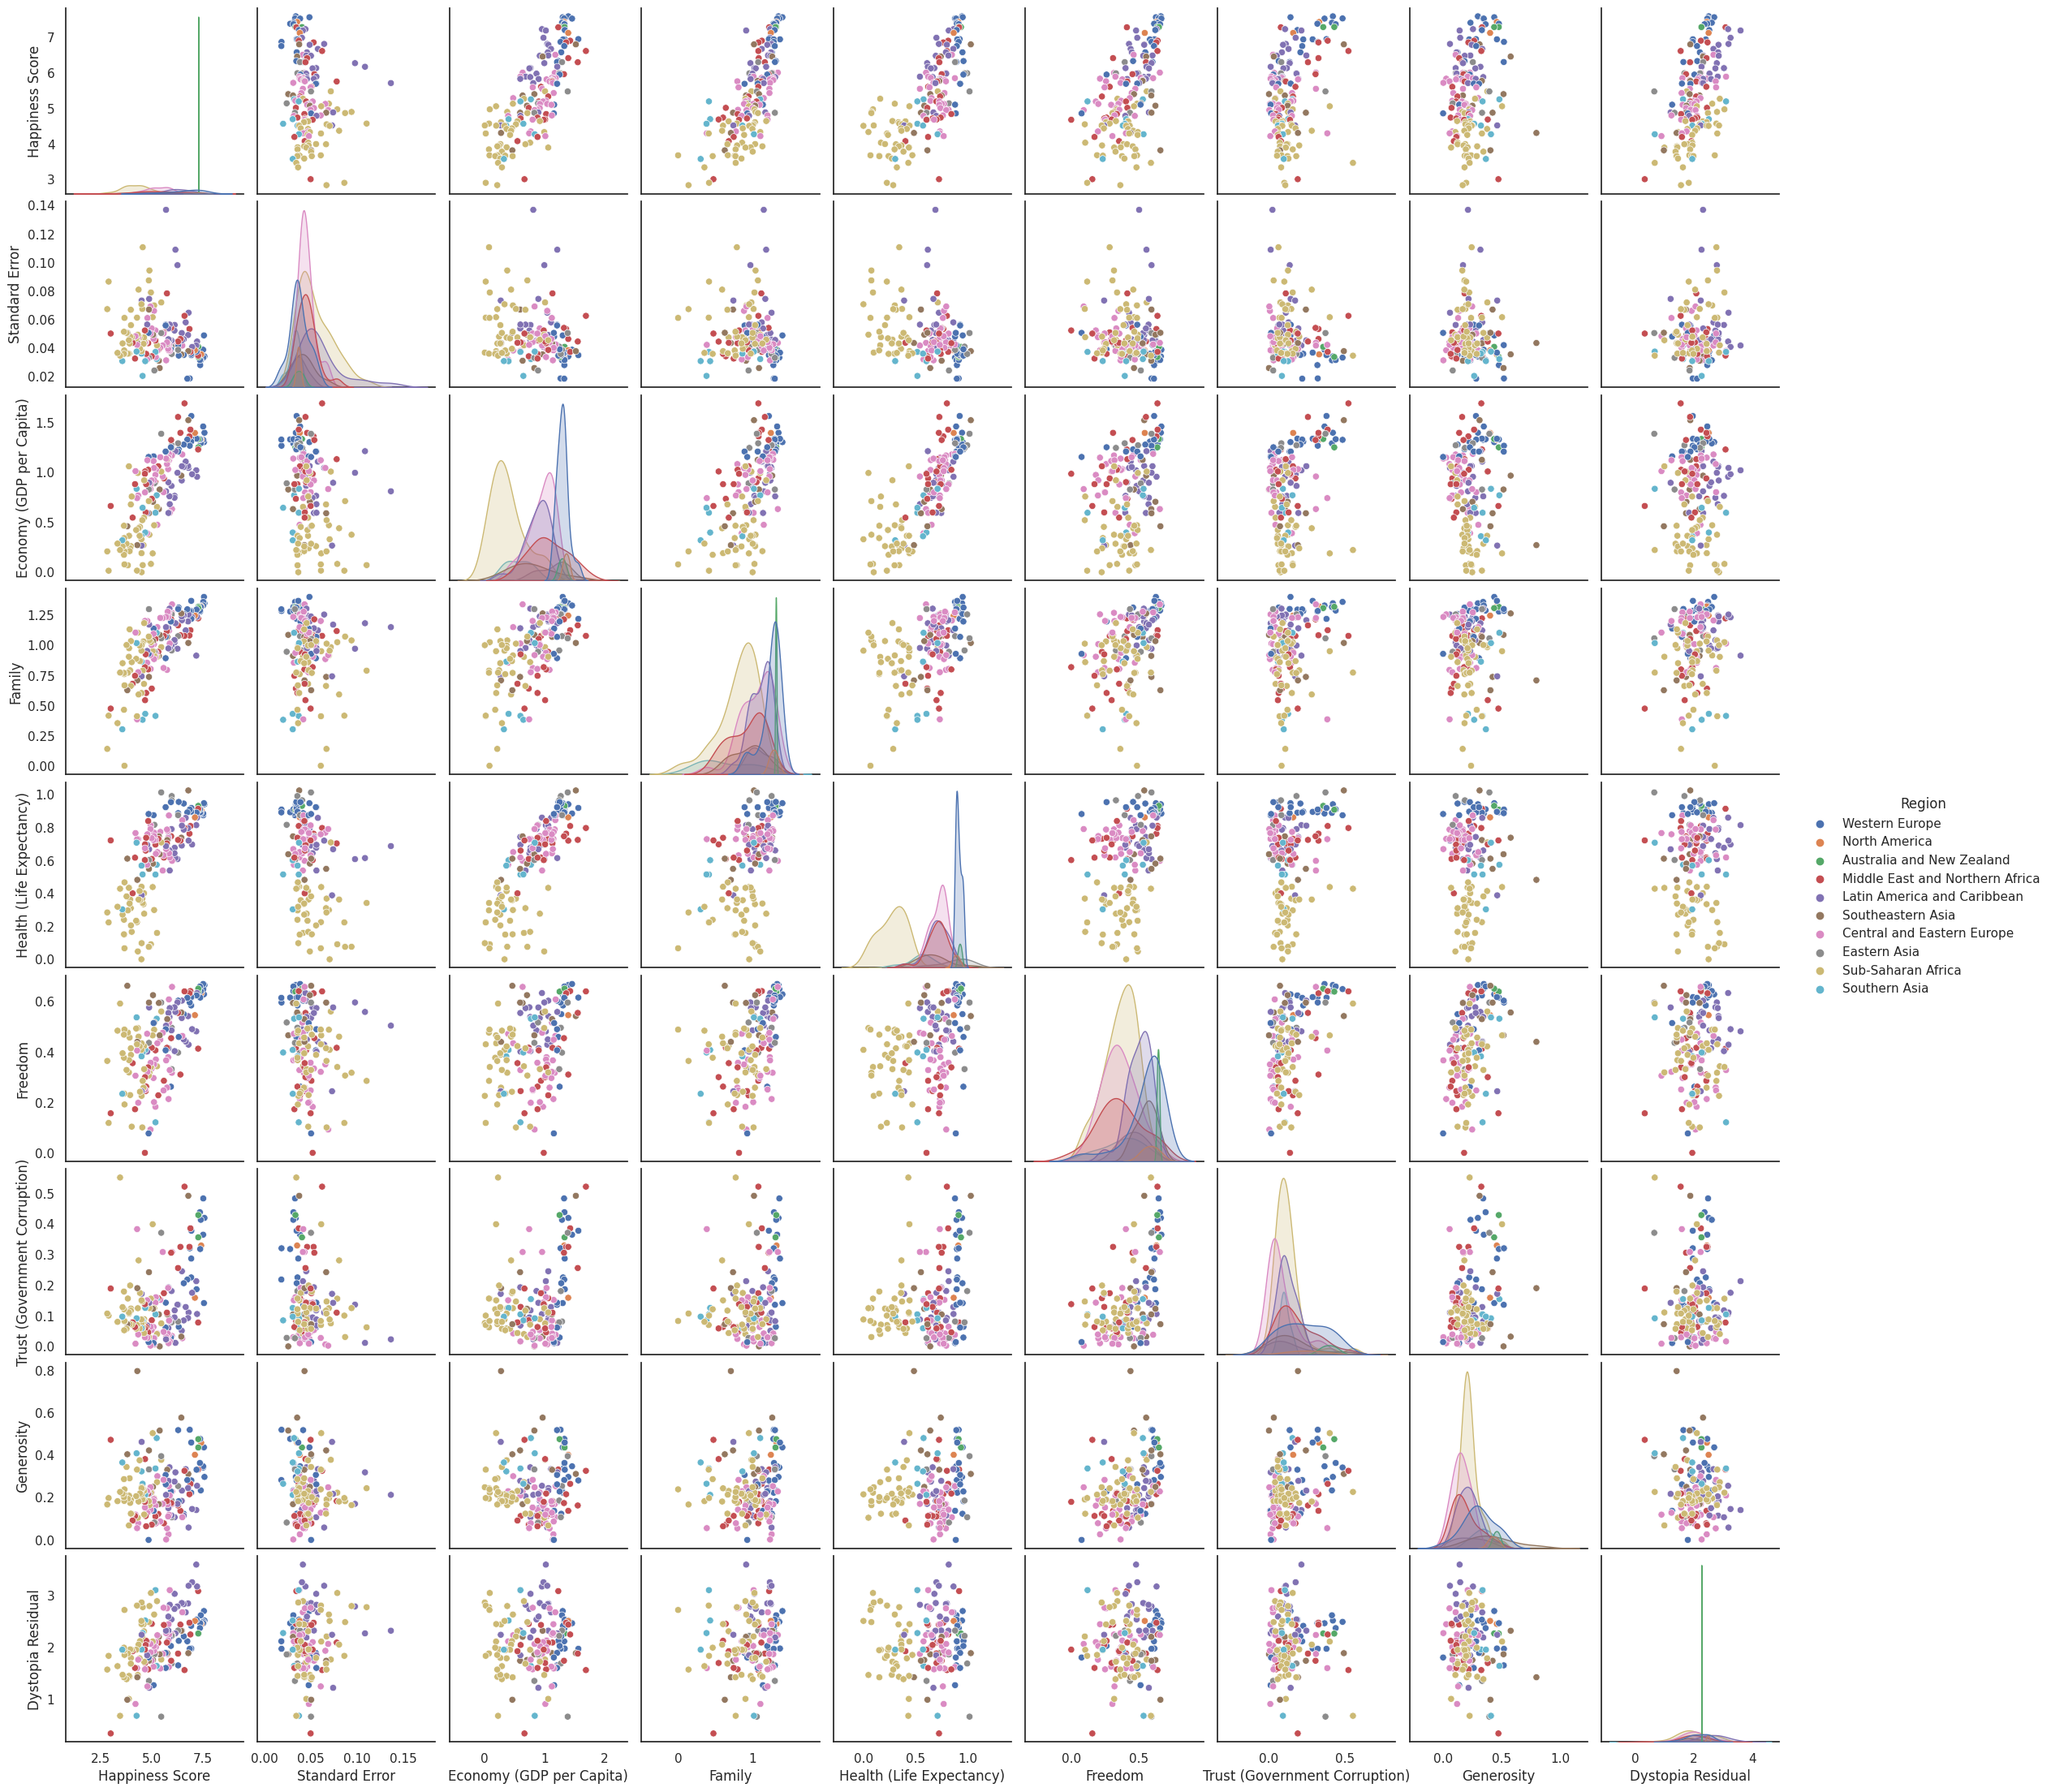

In [17]:
# Pairplot per Region

sns.pairplot(data_2015.drop("Happiness Rank", axis=1), hue='Region');